In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error
from scipy.stats import mode
import seaborn as sns

## 1. Loading data

We load the log returns of the dependent and independent variables, and merge them into one data frame

In [371]:

data_path = "financial_data/" # The folder of the data



# Function to load weekly data and convert "YYYY-WW" format to datetime (Monday of the week)
def load_weekly_data(filename, value_col):
    df = pd.read_csv(data_path + filename)
    
    df['Date'] = pd.to_datetime(df['Date'] + '-1', format='%Y-%W-%w')   # Convert "YYYY-WW" format to datetime (Monday of each week)

    df.set_index('Date', inplace=True) # Set Date as index
    
    df = df[[value_col]] # Keep only the relevant column
    
    return df


# We define the different variables, using the function above. All are defined as weekly log returns 
aker_bp_weekly = load_weekly_data("Aker_BP_weekly.csv", "Log_Returns")
oil_prices = load_weekly_data("Brent_Crude_weekly.csv", "Log_Returns")
osebx = load_weekly_data("OSEBX_weekly.csv", "Log_Returns")
us_treasury = load_weekly_data("US_10Yr_Treasury_weekly.csv", "Log_Returns")


merged_df = aker_bp_weekly.copy() # Merge datasets using outer join to retain all dates

# Dictionary of exogenous variables. 
exogenous_vars = {
    "Oil_Price": oil_prices,
    "OSEBX": osebx,
    "US_Treasury": us_treasury
}

for var_name, df in exogenous_vars.items():
    df_renamed = df.rename(columns={df.columns[0]: var_name})
    merged_df = merged_df.merge(df_renamed, left_index=True, right_index=True, how='outer')


# Remove duplicate dates, if any 
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]

# Reindex to keep the original weekly timestamps
merged_df = merged_df.reindex(aker_bp_weekly.index)  # Ensure all dates match Aker BP weekly data

merged_df.rename(columns={"Log_Returns": "Aker_BP_Log_Returns"}, inplace=True)


# Fill missing values, to the nearest value 
merged_df.ffill(inplace=True)  
merged_df.bfill(inplace=True)  

# Check for no missing values 
print("\nMissing values after filling:")
print(merged_df.isnull().sum())

print(merged_df.head()) # Results show no missing values 



Missing values after filling:
Aker_BP_Log_Returns    0
Oil_Price              0
OSEBX                  0
US_Treasury            0
dtype: int64
            Aker_BP_Log_Returns  Oil_Price     OSEBX  US_Treasury
Date                                                             
2014-01-06            -0.006842  -0.008292  0.000433     0.003344
2014-01-13            -0.004474   0.000672  0.003188    -0.009225
2014-01-20             0.006296  -0.000355  0.002570    -0.002321
2014-01-27            -0.004124   0.002543 -0.005097    -0.008271
2014-02-03            -0.003896  -0.002763 -0.004117    -0.004960


## 2. Simulating the Exogenous Variables

The ARIMAX model relies on future values of the exogeneours variables as inputs for forecasting. To address this, the following approaches were considered:

1. **Simulate the exogenous variables using a predictive model**, such as ARIMA.
2. **Assume the exogenous variables remain constant** over the prediction period.
3. **Assume future values are known**, for example, by using estimates from analysts or financial advisors. This would result in unrealistically accurate predictions.

The first approach was selected. However, after analyzing an ARIMA implementation on the exogeneous variables, simulations assuming a Geometric Brownian Motion was preferred. Can be optimized, but not in scope of project.


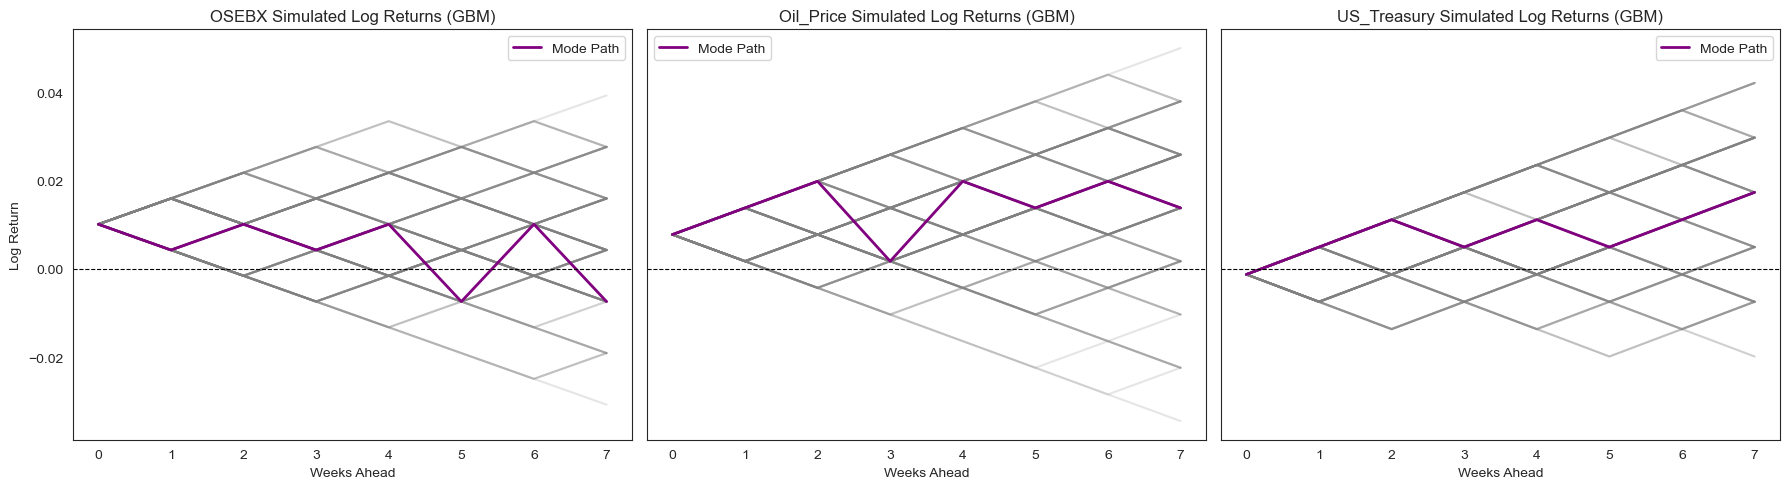

In [372]:
# The data we use for simulation
datasets = {
    'OSEBX': osebx.copy(),
    'Oil_Price': oil_prices.copy(),
    'US_Treasury': us_treasury.copy()
}

target_date = pd.to_datetime('2024-12-31') # Simuation starting period, the same as the start of the testing period
n_steps = 8 # Simulate 8 weeks ahead, equivalent to the prediction period 
n_simulations = 1000 
dt = 1
lookback_for_p = 16  # We look 16 weeks back to find p_up for each exogeneous variables

# Different volatility of the variables makes different lookback periods necessarry
feature_settings = {
    'OSEBX': {'lookback_weeks': 8},
    'Oil_Price': {'lookback_weeks': 4}, # Oil price is volatile, hence the lookback period is shorter
    'US_Treasury': {'lookback_weeks': 16}
}

# Dictionary for storing simulated paths 
mode_paths = {}

# Simulating paths for each exogeneous variable
for name, df in datasets.items():
    settings = feature_settings[name]
    lookback = settings['lookback_weeks']

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep='first')]

    closest_idx = df.index.get_indexer([target_date], method='nearest')[0]  # Closest valid start date, in case missing 
    closest_date = df.index[closest_idx]

    # Estimate volatility from recent returns
    returns_volatility = df.loc[closest_date - pd.DateOffset(weeks=lookback):closest_date]['Log_Returns']
    mu, sigma = returns_volatility.mean(), returns_volatility.std()
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u

    # Estimate p_up from 16 weeks of data 
    returns_direction = df.loc[closest_date - pd.DateOffset(weeks=lookback_for_p):closest_date]['Log_Returns']
    p_up = (returns_direction > 0).mean()

    # Starting value
    start_value = df.iloc[closest_idx]['Log_Returns']

    # Simulate paths
    simulated = np.zeros((n_simulations, n_steps))
    for i in range(n_simulations):
        path = [start_value]
        for _ in range(1, n_steps):
            step = np.log(u) if np.random.rand() < p_up else np.log(d)
            path.append(path[-1] + step)
        simulated[i] = path

    # Mode path
    mode_path = mode(simulated, axis=0, keepdims=False)[0].flatten()
    mode_paths[name] = (mode_path, simulated)

# --- Plot Simulations ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for ax, (name, (mode_path, simulated)) in zip(axs, mode_paths.items()):
    for i in range(100):
        ax.plot(range(n_steps), simulated[i], color='gray', alpha=0.2)
    ax.plot(range(n_steps), mode_path, color='purple', linewidth=2, label='Mode Path')
    ax.set_title(f'{name} Simulated Log Returns (GBM)')
    ax.set_xlabel('Weeks Ahead')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.legend()

axs[0].set_ylabel('Log Return')
plt.tight_layout()
plt.show()


## 3. Finding the best parameters for the ARIMAX model

To improve the performance of the ARIMAX model, we aim to find the combination of parameters that results in the best fit to the training data. The model has three key parameters: **p**, **d**, and **q**. These represent the number of autoregressive terms, the degree of differencing needed to make the time series stationary, and the number of moving average terms, respectively. By trying out different combinations of these values, we can evaluate which setup gives us the most accurate and reliable predictions. The goal is to identify the model configuration with the lowest AIC (Akaike Information Criterion), which serves as a measure of model quality. 

The best parameter combination was (0, 0, 0), with an AIC of -3851.20, indicating that a simple model fits the data best.



In [373]:
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
merged_df = merged_df.asfreq('W-MON')
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

train_end = pd.to_datetime('2024-12-31')
train_data = merged_df.loc[:train_end]
test_data = merged_df.loc[train_end:]

Y_train = train_data['Aker_BP_Log_Returns']
X_train = train_data[['Oil_Price', 'OSEBX', 'US_Treasury']]

import warnings
warnings.filterwarnings("ignore")

best_aic = float('inf')
best_order = None

for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = SARIMAX(Y_train, exog=X_train, order=(p, d, q),
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMAX order: {best_order} with AIC: {best_aic}")


Best ARIMAX order: (0, 0, 0) with AIC: -3851.1950167016985


## 4. Fitting the data to optimal ARIMAX model, and plotting results of 8 week prediction

                                SARIMAX Results                                
Dep. Variable:     Aker_BP_Log_Returns   No. Observations:                  574
Model:                         SARIMAX   Log Likelihood                1929.598
Date:                 Tue, 25 Mar 2025   AIC                          -3851.195
Time:                         17:11:05   BIC                          -3833.791
Sample:                     01-06-2014   HQIC                         -3844.406
                          - 12-30-2024                                         
Covariance Type:                   opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Oil_Price       0.3143      0.027     11.650      0.000       0.261       0.367
OSEBX           1.5353      0.057     26.814      0.000       1.423       1.648
US_Treasury    -0.0930      0.018     -5

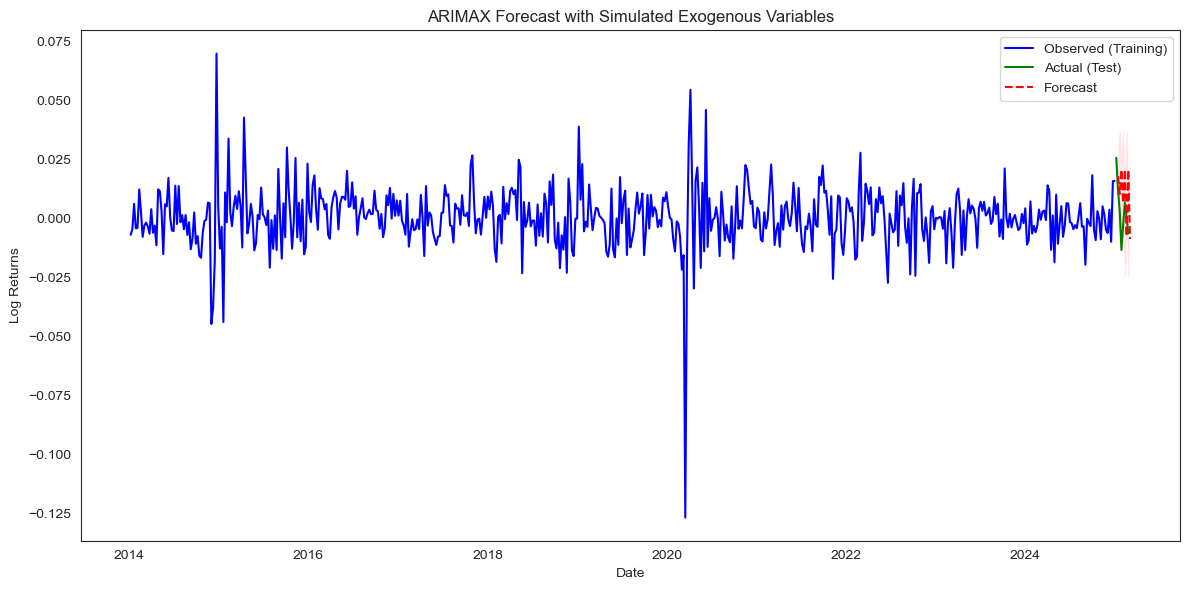

In [374]:

sns.set_style("white") # Defining style of plot 

# We use the merged data of all the log returns 
merged_df.index = pd.to_datetime(merged_df.index)
merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
merged_df = merged_df.asfreq('W-MON')
merged_df.ffill(inplace=True) # Handle missing values   
merged_df.bfill(inplace=True) # Handle missing values 

train_end = pd.to_datetime('2024-12-31') 
train_data = merged_df.loc[:train_end] # We train on data from start of dataset (2014) until this 2024-12-31
test_data = merged_df.loc[train_end:] # We predict/test on remainder of dataset 

# We define the dependent and independent variables 
Y_train = train_data['Aker_BP_Log_Returns'] 
X_train = train_data[['Oil_Price', 'OSEBX', 'US_Treasury']]


# Using the optimal parameters, the SARIMAX (Seasonal Arimax)
order = (0,0,0)
model = SARIMAX(Y_train, exog=X_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

print(results.summary())

# We define the dates for forecasting
forecast_dates = pd.date_range(start=train_end + pd.Timedelta(weeks=1), periods=n_steps, freq='W-MON')

# We use the simulated values from step 2 in the prediction 
simulated_exog = pd.DataFrame(index=forecast_dates)
for var in ['Oil_Price', 'OSEBX', 'US_Treasury']:
    simulated_exog[var] = mode_paths[var][0]  # mode path

# Initializing list for storing predicted values and confidence intervals 
forecast_values, forecast_ci_lower, forecast_ci_upper = [], [], []

forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)


forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean.values,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
}, index=forecast_dates)


plt.figure(figsize=(12, 6))
sns.lineplot(x=train_data.index, y=train_data['Aker_BP_Log_Returns'], label='Observed (Training)', color='blue')
sns.lineplot(x=test_data.index, y=test_data['Aker_BP_Log_Returns'], label='Actual (Test)', color='green')
sns.lineplot(x=forecast_df.index, y=forecast_df['Forecast'], linestyle='dashed', color='red', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='pink', alpha=0.3)
plt.title('ARIMAX Forecast with Simulated Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


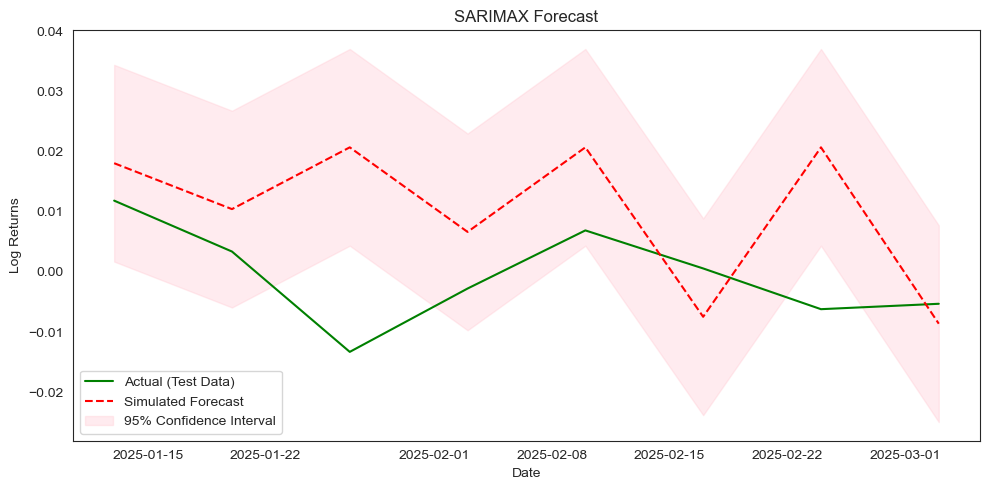

In [375]:
# Only the test period is plotted


# Rebuild forecast_df to ensure alignment
forecast = results.get_forecast(steps=n_steps, exog=simulated_exog)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Force correct datetime index
forecast_mean.index = forecast_dates
forecast_ci.index = forecast_dates

# Reassign forecast_df with proper alignment
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=forecast_dates)

# Align actuals with forecast
actual_values = merged_df.reindex(forecast_df.index)['Aker_BP_Log_Returns']
valid_idx = actual_values.notna() & forecast_df['Forecast'].notna()
actual_values = actual_values[valid_idx]
forecast_series = forecast_df['Forecast'][valid_idx]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Actual values
plt.plot(actual_values.index, actual_values.values, label='Actual (Test Data)', color='green')

# Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], linestyle='dashed', color='red', label='Simulated Forecast')

# Confidence Interval (aligned)
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    color='pink',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.tight_layout()
plt.show()


# 5. Performance metrics

In [376]:
# Metrics using imported functions 
mse = mean_squared_error(actual_values, forecast_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast_series)
max_err = max_error(actual_values, forecast_series)

print(f"Metrics are: \n mse: {mse} \n rmse: {rmse} \n mae: {mae} \n max_err: {max_err}")


Metrics are: 
 mse: 0.00029032530040337765 
 rmse: 0.017038934837699735 
 mae: 0.013591959159059783 
 max_err: 0.03399753266370489
